# Breast Cancer Detection

The white paper instructs me to develop a means to diagnose breast cancer based on the data containing a number of features observed in a biopsy.

1. What features of a cell are the largest drivers of malignancy?
2. How would a physician use your product?
3. There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

## Key Takeaways

  - There are many repeated rows, mostly involving those with a "malignant" diagnosis.
  - The only missing data appears in 79 rows, each of which has nearly all its data missing. This could be due to a clinician who is not entering data correctly. I would recommend finding out the cause of this discrepancy.
  - A simple logistic model trained on 80% of the data (and tested on the remaining 20%) achieves an F1 score of 0.964, (very good). It achieved a ROC AUC of 0.956 (also very good). It correctly classified 53 malignant tests, 36 benign tests. It incorrectly classified 2 benign and 2 malignant tests.
  - The three most important features are 1.`Clump Thickness`, 2. `Single Epithelial Cell Size`, and 3. `Bland Chromatin`  In fact, when running a classifier on these three columns alone we achieve a nearly identical confusion matrix, F1 score (0.954), and ROC AUC (0.946). Because of this, **resources could be saved by measuring only these three features**, and the model obtained would **perform just as well.**
  - Once put into production, a clinician could input these three (or 9) numbers into my logistic regression model to diagnose.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import scikitplot as skplt

import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

imports = [pd, np, sns, sklearn, ]
for pkg in imports:
    print(f'{pkg.__name__} is at version {pkg.__version__}.')

pandas is at version 0.24.2.
numpy is at version 1.16.2.
seaborn is at version 0.9.0.
sklearn is at version 0.20.3.


In [2]:
data_dir = '/home/amaurer/Documents/Data Challenge/data/'
data_file = 'breast_cancer_detection.txt'

data = pd.read_csv(data_dir + data_file)
data.head()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


In [3]:
data = data.drop(['Index', 'ID'], axis=1)

# Data Preprocessing

## `Class` Column

The `Class` column is a mess with missing data and the labeling system. Because the ration of `20` to `40` were about equal to the ratio of `2` to `4` (both around 3%) I decided to keep `20`s as benign and `40`s as malignant.

In [4]:
data.Class.unique()

array(['4', '2', 'No idea', '40', nan, '#', '?', '20'], dtype=object)

In [5]:
data.Class.value_counts(dropna=False)

4          15164
2            456
40           151
NaN           28
?             23
No idea       17
#             11
20             5
Name: Class, dtype: int64

In [6]:
class_dict = {'#':np.nan, '2':0, '20':0, '4':1, '40':1, '?':np.nan, 'No idea':np.nan}
data.Class = data.Class.map(class_dict)

data.Class.value_counts(dropna=False)

1.0    15315
0.0      461
NaN       79
Name: Class, dtype: int64

## Other Columns

The data was so messy in `Class` that I should check what's going on in every other column. It turns out they all have some level of data messiness. Lucky for me these are all on a scale from 1 to 10 so I can use a single dictionary to fix it. Unfortunately for me this means `10`s could in fact be `1`s. Might need to do some anomaly detection later.

In [7]:
data.columns

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')

In [8]:
dirty_cols = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']

for col in dirty_cols:
    print(f'{col}:')
    print(data[col].unique())

Clump Thickness:
[  7   6   8   5  10   3   4   1  70  80 100   2   9  50  30  40  60]
Uniformity of Cell Size:
['8' '10' '6' '5' '4' '9' '3' '1' 'No idea' '2' '7' '50' '100' '30' nan
 '#' '?' '80' '40' '60' '90' '20']
Uniformity of Cell Shape:
['3' '5' '4' '6' '10' '7' '1' 'No idea' '2' '60' '100' '40' nan '#' '9'
 '8' '?' '30' '50' '70']
Marginal Adhesion:
['7' '5' '10' '3' '6' '4' '1' '2' 'No idea' '30' '40' nan '#' '8' '?' '70'
 '60' '100' '50' '9' '20']
Single Epithelial Cell Size:
['4' '10' '3' '6' '2' '8' 'No idea' '1' '30' nan '5' '#' '?' '40' '20' '7'
 '60' '80' '100' '9']
Bare Nuclei:
['5' '10' '1' '8' '2' '3' '6' 'No idea' '?' '80' '60' '30' nan '100' '#'
 '9' '50' '7' '4' '20']
Bland Chromatin:
['7' '6' '3' '2' '4' 'No idea' '1' '5' '70' '30' nan '40' '#' '10' '8' '?'
 '20' '9' '60' '50']
Normal Nucleoli:
['8' '10' '5' '4' '3' '7' '2' '6' '9' '1' 'No idea' '40' '90' '20' nan
 '30' '#' '?' '80' '60' '50' '100' '70']
Mitoses:
['2' '1' '7' 'No idea' '3' '10' '70' '8' nan '20' 

In [9]:
cleaning_dict = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 20:2, 30:3, 40:4, 50:5, 60:6, 70:7, 80:8, 90:9, 100:10}

def to_int(maybe_num):
    try:
        return cleaning_dict[int(maybe_num)]
    except:
        return np.nan
    
for col in dirty_cols:
    data[col] = data[col].apply(to_int)

In [10]:
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,7,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,1.0
1,6,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,1.0
2,8,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,1.0
3,7,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,1.0
4,5,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,1.0


In [11]:
for col in dirty_cols:
    print(f'{col}:')
    print(sorted(data[col].unique()))

Clump Thickness:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Uniformity of Cell Size:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
Uniformity of Cell Shape:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
Marginal Adhesion:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
Single Epithelial Cell Size:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
Bare Nuclei:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
Bland Chromatin:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan, 8.0, 9.0, 10.0]
Normal Nucleoli:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
Mitoses:
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan, 8.0, 10.0]


## Count rows with missing data

Only about 0.6% of rows have missing data, and each row with NaN has several missing components. This seems to point towards some clinicians entering data poorly. Because the missing data is so sparse, I have decided to drop it.

In [12]:
data.loc[data['Uniformity of Cell Size'].isna()].head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
30,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data.loc[data['Uniformity of Cell Size'].isna()].shape

(79, 10)

In [14]:
n = data.shape[0]
has_na = n - data.dropna(axis=0).shape[0]

print(f'There are {has_na} rows with NaNs, of {n} total rows.\nThis is {round(100 * has_na / n, 2)}% of data.')

There are 95 rows with NaNs, of 15855 total rows.
This is 0.6% of data.


In [15]:
data = data.dropna(axis=0)

In [16]:
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,7,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,1.0
1,6,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,1.0
2,8,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,1.0
3,7,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,1.0
4,5,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,1.0


## Deal with Duplicated Rows

It turns out that so many of the rows are duplicates. So we will drop them.

In [17]:
full_size = data.shape[0]
reduced_size = data.drop_duplicates().shape[0]

In [18]:
print(f'Originally had {full_size} rows, but most were duplicates.\nUpon deleting duplicate rows we are left with {reduced_size} rows.')
print(f'After removing duplicate rows, roughly {round(100*reduced_size/full_size,2)}% of the data remains')

Originally had 15760 rows, but most were duplicates.
Upon deleting duplicate rows we are left with 465 rows.
After removing duplicate rows, roughly 2.95% of the data remains


In [19]:
data = data.drop_duplicates()

# Exploratory Data Analysis

Since this data is rather discrete (only ordinal data), I think a correlation matrix will do us well. Here's a heatmap version, with lighter colors implying a high positive correlation.

In [20]:
data.Class.value_counts()

1.0    247
0.0    218
Name: Class, dtype: int64

The data is not unbalanced.

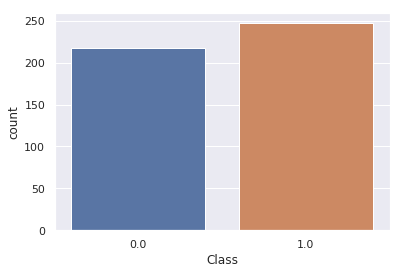

In [21]:
sns.countplot(data.Class)

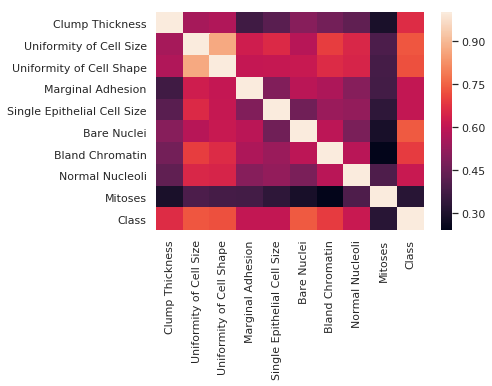

In [22]:
sns.heatmap(data.corr())

Now let's visualize the distribution of each of these plots.

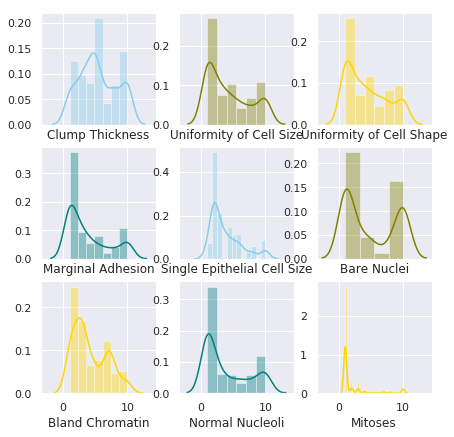

In [23]:
f, axes = plt.subplots(3, 3, figsize=(7, 7), sharex=True)
sns.distplot( data["Clump Thickness"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["Uniformity of Cell Size"] , color="olive", ax=axes[0, 1])
sns.distplot( data["Uniformity of Cell Shape"] , color="gold", ax=axes[0, 2])
sns.distplot( data["Marginal Adhesion"] , color="teal", ax=axes[1, 0])
sns.distplot( data["Single Epithelial Cell Size"] , color="skyblue", ax=axes[1,1])
sns.distplot( data["Bare Nuclei"] , color="olive", ax=axes[1,2])
sns.distplot( data["Bland Chromatin"] , color="gold", ax=axes[2,0])
sns.distplot( data["Normal Nucleoli"] , color="teal", ax=axes[2,1])
sns.distplot( data["Mitoses"] , color="gold", ax=axes[2,2])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

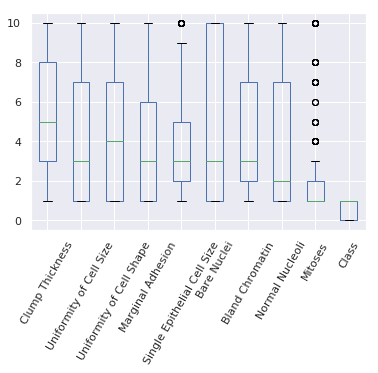

In [24]:
data.boxplot()
plt.xticks(rotation=60)

# Modeling

## Train-Test Split

Based on what I know about the data, each observation should be independent of the previous ones. As such, I will shuffle the data (to be safe) and randomly select an 80/20 train/test split. Later I might come back to do a 70/15/15 train/validation/test split.

In [25]:
X = data.drop('Class', axis=1)
y = data.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Logistic Regression Model

Because the data seems to have very little covariance between columns, I will start with a linear model.

In [26]:
logistic_model = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

This logistic model is actually doing a fabulous job classifying on the test set, as is shown in this confusion matrix.

In [27]:
confusion_matrix(y_test, y_pred)

array([[32,  1],
       [ 6, 54]])

In [28]:
f1_score(y_test, y_pred)

0.9391304347826087

## ROC AUC

This ROC score is also very high, indicating that we have a good model which separates positive and negative predictions *very* well.

In [29]:
roc_auc_score(y_test, y_pred)

0.9348484848484848

Here I'm converting the data so it can be plotted in a nice form.

In [30]:
y_test_mat = np.zeros([y_test.shape[0],2])
y_test_mat[:,1] = y_test
y_test_mat[:,0] = 1 - y_test_mat[:,1]

In [31]:
y_pred_mat = np.zeros([y_test.shape[0],2])
y_pred_mat[:,1] = y_pred
y_pred_mat[:,0] = 1 - y_pred_mat[:,1]

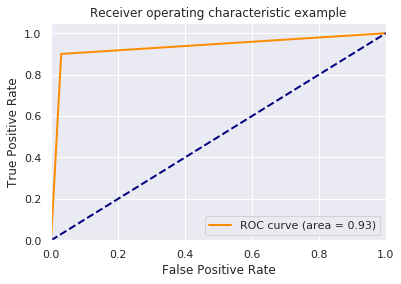

In [32]:
n_classes=2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_mat[:, i], y_pred_mat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_mat.ravel(), y_pred_mat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Feature Importance

The three most important features are `Clump Thickness` and `Marginal Adhesion`, `Uniformity of Cell Size`.

In [33]:
pd.DataFrame({'Col':X_train.columns, 'Importance':logistic_model.coef_[0]}).sort_values(by='Importance', ascending=False)

,Col,Importance
0,Clump Thickness,0.689010
6,Bland Chromatin,0.477242
4,Single Epithelial Cell Size,0.348263
3,Marginal Adhesion,0.253717
5,Bare Nuclei,0.251207
1,Uniformity of Cell Size,0.207424
7,Normal Nucleoli,0.049632
2,Uniformity of Cell Shape,-0.108313
8,Mitoses,-0.210199


Let's train a model only on these three coolumns and see its performance.

In [34]:
imp_cols = ['Clump Thickness', 'Single Epithelial Cell Size', 'Bland Chromatin']
X_train2 = X_train[imp_cols]
X_test2 = X_test[imp_cols]

In [35]:
logistic_model2 = LogisticRegression(solver='lbfgs').fit(X_train2, y_train)

y_pred2 = logistic_model2.predict(X_test2)

In [36]:
confusion_matrix(y_test, y_pred2)

array([[32,  1],
       [ 6, 54]])

In [37]:
f1_score(y_test, y_pred2)

0.9391304347826087

In [38]:
roc_auc_score(y_test, y_pred2)

0.9348484848484848

The confusion matrix, F1 score, and ROC AUC are nearly identical, and thus you could achieve predictions nearly as accurate without measuring the remaining 6 features.